# Lab 2: Supervised Learning

In this lab, we prepare our Kiva data for a linear regression, and run linear regressions that attempt to answer questions we may have as Kiva borrowers: 

1. How much should I ask for on Kiva? 
2. When will I receive my loan? (i.e. when will my loan be disbursed to me?) 

In the language of Module 1, our outcome features are: 

1. loan_amount
4. days_to_disburse (we will make this variable in this notebook!)

We will try using and evaluating different explanatory features in this notebook. 

But first, we will load the packages we need for this section, and our data. As a reminder, we had 3 raw data files (loans_full, loans_detail, and loans_partner_details). In Notebook 1, we merged these data files to form the data frame "df", which we will  use now.  

In [1]:
## Import packages

import pandas as pd
import numpy as np
from datetime import datetime
from ggplot import *
%matplotlib inline

In [2]:
## Read in data

##data_path = '~/intro_to_machine_learning/data'
data_path = '~/Desktop'
df = pd.read_csv(data_path+'/df.csv', low_memory=False)

## Creating Explanatory Features of Interest

   ### Demographics

Since we are interested in using the demographics of the Kiva borrowers as potential explanatory features, we will create these based on existing data. See how below: 

In [3]:
## Male/Female 
#  Note the apply function
df['male'] = df['borrowers'].apply(lambda x: x.split("gender': '")[1][0]=='M')

## Whether or not the borrower is widowed
#  Note the str.contains function
df['widowed'] = np.where(df['description.texts.en'].str.contains("widowed|widow", na=False) ==True, True, False)

## Whether or not the borrower has children 
df['kids'] = np.where(df['description.texts.en'].str.contains("kids|child|children|kid|son|daughter", na=False) ==True,True,False)

Here we see two new methods used to create features: apply and string searches. 

To create the "male" feature, we are using the feature "borrowers". An observation from this feature looks like this: 

    [{'first_name': 'James', 'last_name': '', 'gender': 'M', 'pictured': True}]

By using apply, we split each observation (using x.split) along the section of the string that says 'gender'. Then we code the feature "male" to be 1 or 0 depending on whether the string says "M" or "F". 

In creating the "widowed" and "kids" feature, we are using Numpy's "where" function and "str.contains" to filter the data such that we are only creating a Boolean variable for those observations in which we find the strings of interest. 

Read more here: 

On np.where:
https://docs.scipy.org/doc/numpy/reference/generated/numpy.where.html

On pandas' str.contains:
https://pandas.pydata.org/pandas-docs/stable/generated/pandas.Series.str.contains.html

### Loan features

Next we create features that tell us the specific conditions surrounding each loan posting, including: 
1. Whether or not a borrower has included a video or a picture

    Here, our intuition tells us that if a borrower includes more personal details and imagery, lenders are more likely to lend to them. We create this variable so we can differentiate between loans that have these personal details and loans that do not.

    
2. When loans are funded
3. When loans are disbursed
4. When loans expire

In [4]:
## Features of the loan posting

## Does the borrower include a video? 
df['video'] = np.where(pd.isnull(df['video.id']) ==False, True, False)

## Does the borrower include a picture? 
df['pictured'] = df['borrowers'].apply(lambda x: x.split("gender': '")[1][0]==True)

In order to get information on how much time it took for a loan to be funded or be disbursed or expire, we first need to make sure that the data is in Python's datetime format. Once all relevant features are converted to this format, we can perform operations on them. In this case, we want to find out how many days elapsed between two dates, so we subtract the earlier date from the later date. 

In [5]:
df = df.rename(columns={'terms.disbursal_date': 'disbursal_date'})

## convert columns to datetime format
df['funded_date_cln'] = pd.to_datetime(df.funded_date.str[:10], infer_datetime_format=True)
df['post_date_cln'] = pd.to_datetime(df.posted_date.str[:10], infer_datetime_format=True)
df['disb_date_cln'] = pd.to_datetime(df.disbursal_date.str[:10], infer_datetime_format=True)
df['exp_date_cln'] = pd.to_datetime(df.planned_expiration_date.str[:10], infer_datetime_format=True)

## Time to fund is the funded date minus the posted date
df['time_to_fund'] =df['funded_date_cln'] - df['post_date_cln']
df['days_to_fund'] = df.time_to_fund.dt.days

## Time to dispursement is the Disbursed date minus the Posted Date
df['time_to_disb'] =df['disb_date_cln'] - df['post_date_cln']
df['days_to_disb'] = df.time_to_disb.dt.days

## Time to expiration is the expiration date minus the Posted Date
df['time_to_exp'] =df['exp_date_cln'] - df['post_date_cln']
df['days_to_exp'] = df.time_to_exp.dt.days

## Checking Assumptions

### Normality
In Module 2, we reviewed that normal distribution of variables is an assumption underlying linear regression. Here, we go over an example of abnormal distribution and explain why it is inappropriate to use in a regression.

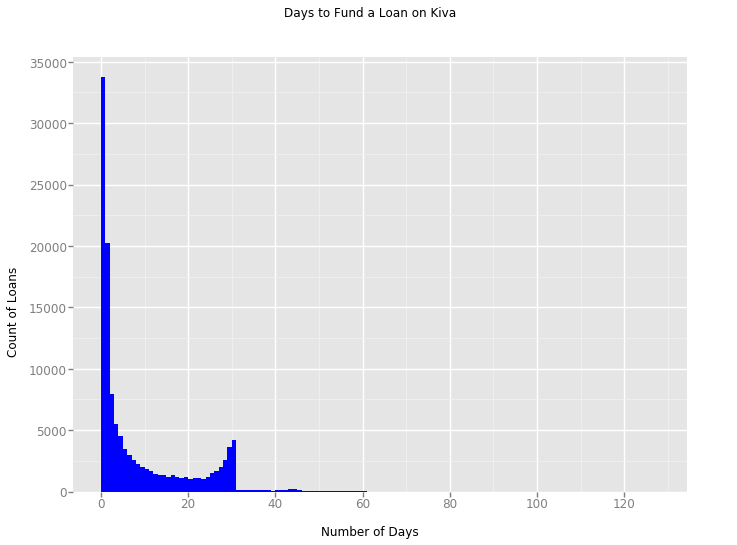

<ggplot: (134664615579)>

In [6]:
ggplot(df.query('days_to_fund >= 0'), aes(x='days_to_fund')) + geom_histogram(binwidth=1, fill="blue") + \
ggtitle("Days to Fund a Loan on Kiva") + xlab("Number of Days") + ylab("Count of Loans")

Most loans are funded astoundingly quickly! The majority of loans are funded 0 days after being posted. There is also a spike that occurs around the 30 day mark, suggesting that there is a cluster of loans that are funded before the expiration date of 30 days.

In concept, the number of days that it takes a loan to fund would be very interesting as an outcome feature. However, due to the fact that most loans get fulfilled immediately or at the 30-day mark, the model would not be very good at predicting the days it would take to fund any new loans. Rather, the model would predict that any loan would be fulfilled either immediately or at Day 30. 

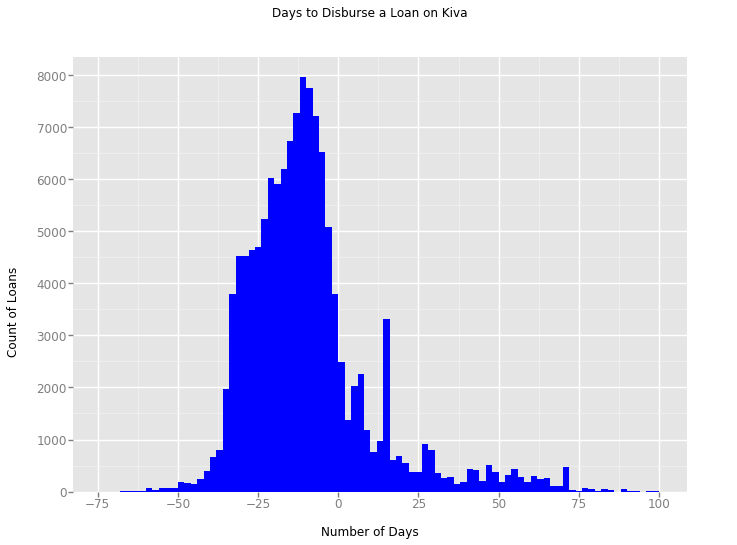

<ggplot: (134643936183)>

In [7]:
ggplot(df.query('days_to_disb < 100 & days_to_disb > -100'), aes(x='days_to_disb')) + geom_histogram(binwidth=2, fill="blue") + \
ggtitle("Days to Disburse a Loan on Kiva") + xlab("Number of Days") + ylab("Count of Loans")

Note that this histogram exhibits a normal distribution. Interestingly, it is centered around -10. This implies that the average loan gets disbursed to the borrower <b>prior</b> to getting posted. 

At this point, we would consult with Kiva to make sure that our understanding of the data is correct. Based on our conversations with Kiva representatives, we found out that Kiva encourages partners to disburse loans to borrowers in case there are time-sensitive loans. In the area of agriculture, for example, it is understandable that a borrower might need capital right away in order to plant crops while the season is right. 

Now let's look to loan_amount.

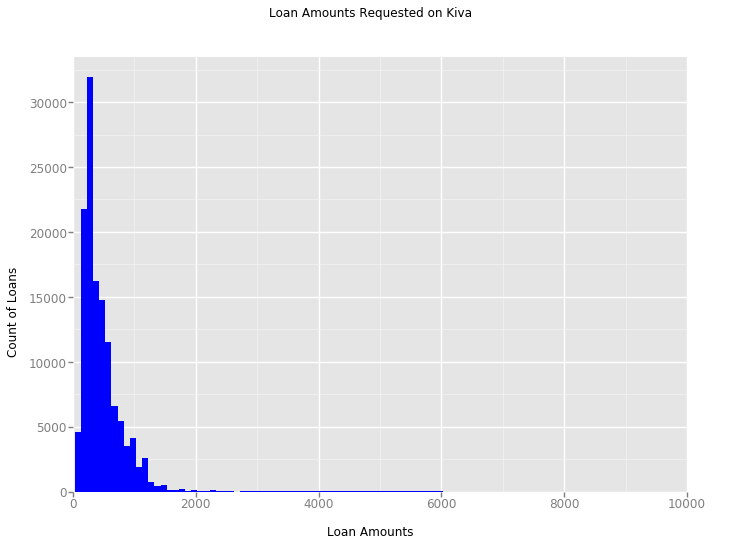

<ggplot: (-9223371941954301717)>

In [7]:
ggplot(df, aes(x='loan_amount')) + geom_histogram(binwidth=100, fill="blue") + xlim(0, 10000) + \
ggtitle("Loan Amounts Requested on Kiva") + xlab("Loan Amounts") + ylab("Count of Loans")

### Check for multicollinearity

Numpy's Corrcoef function returns a matrix of Pearson correlation coefficients. To recap Module 2's lesson, multicollinearity is a problem when we have highly correlated explanatory features, as this makes it difficult for the model to try to differentitae between each feature's influence on the explanatory feature. Read more about Numpy's Corrcoef here: https://docs.scipy.org/doc/numpy-1.10.1/reference/generated/numpy.corrcoef.html

Try running different features!

In [8]:
np.corrcoef(df.loan_amount, df.funded_amount)

array([[ 1.        ,  0.97373115],
       [ 0.97373115,  1.        ]])

This tells us that loan amount and funded amount are extremely highly correlated - a vast majority of loans requested get funded! Normally, we would be interested in both loan_amount and funded_amount as an outcome feature, but here we see that it would be redundant to test both. 

In [9]:
np.corrcoef(df.lender_count, df.funded_amount)

array([[ 1.        ,  0.95874758],
       [ 0.95874758,  1.        ]])

## Linear Regression

Now we're relatively confident about what our data looks like, let's try some regressions. We will focus in on outcome features time_to_disburse and loan_amount. We encourage you to explore other outcome features!  

As discussed in Module 2, we will divide the data into training and test sets so we can validate our regression results.

Note that training set should be larger than the test set, as we should train our model on as much data as possible. For this example, we divide the data 80% training / 20% test.

In [10]:
import statsmodels.formula.api as sm
from sklearn import linear_model
from sklearn.model_selection import train_test_split

In [11]:
# Set training-test split %
split_pct = 0.80

# Remove NaN values
df_cln = df[pd.notnull(df['loan_amount'])]

# the pandas command "sample" already randomizes its selection. 
loans_full_shuffled = df_cln.sample(frac=1)

train_set = loans_full_shuffled[:int((len(loans_full_shuffled)+1*split_pct))] 
test_set = loans_full_shuffled[int(len(loans_full_shuffled)*split_pct+1):]  

# Now we have two separate datasets: train_set and test_set. We will run the regression on train_set
# using statsmodel's "ols" function. Let's try a simple example to start:

model0 = sm.ols(formula="loan_amount ~ male", data=train_set).fit()
print(model0.summary())

                            OLS Regression Results                            
Dep. Variable:            loan_amount   R-squared:                       0.006
Model:                            OLS   Adj. R-squared:                  0.006
Method:                 Least Squares   F-statistic:                     829.5
Date:                Fri, 26 May 2017   Prob (F-statistic):          7.99e-182
Time:                        15:40:23   Log-Likelihood:            -1.0162e+06
No. Observations:              127958   AIC:                         2.032e+06
Df Residuals:                  127956   BIC:                         2.032e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------
Intercept      435.2965      2.295    189.703   

This is a lot to digest! Remember that our simple model can be represented as a linear equation, like this: 

    loan_amount = intercept + coef*male

Therefore, these results can be translated as follows: 

    loan_amount = intercept + 118.0963*male

Noticeably, the coefficient for male is not small, suggesting that whether or not a borrower is male does influence loan_amount. However, the Adjusted R Squared is 0.006 - extremely low. This suggests that the predictive value of male is pretty low - it cannot be used as the single feature to predict loan_amount. 

This result is in line with our understanding of the world - there must be other factors influencing loan_amount. Let's try complicating the model by adding more explanatory features. 

#### Model 1

In [12]:
model1 = sm.ols(formula="loan_amount ~ days_to_exp + borrower_count + sector + kids + male+ widowed + pictured + video", data=train_set)
model1_results = model1.fit()
print(model1_results.summary())

                            OLS Regression Results                            
Dep. Variable:            loan_amount   R-squared:                       0.162
Model:                            OLS   Adj. R-squared:                  0.162
Method:                 Least Squares   F-statistic:                     996.1
Date:                Fri, 26 May 2017   Prob (F-statistic):               0.00
Time:                        15:40:28   Log-Likelihood:            -8.1874e+05
No. Observations:              103045   AIC:                         1.638e+06
Df Residuals:                  103024   BIC:                         1.638e+06
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------------------
Intercept               

This model is more aligned with our understanding of the world. We see that Education and Health are sectors that get much larger loans, rather than sectors like Personal Use. We also see that males tend to get larger loans, and widows tend to get slightly smaller loans. 

## Model Validation

<i>How can we evaluate how our model is doing? </i>

In the previous section, we were able to get general ideas of how well our model was doing by using metrics like Adjusted R Squared, coefficients, and p-value. However, the goal of most machine learning is a model that is <b>predictive</b>. Recall that we randomly split our dataset into a training set (80%) and a test set (20%). Now we will use the results from the regression conducted on our training set to predict the outcome features for each observation in our test set. The difference between the predicted outcome feature and the actual outcome feature for each observation gives us an idea of how close we are to the mark.  

In [13]:
import matplotlib.pyplot as plt

#### Validation of Model 1: 

In [ ]:
y_pred = model1_results.predict(test_set)

In [ ]:
from sklearn import datasets, linear_model
from sklearn.metrics import explained_variance_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

In [ ]:
y_true = test_set['loan_amount']
y_pred = y_pred['predictions']

## Explained variance from the model
explained_variance_score(y_true, y_pred, multioutput='raw_values')

In [ ]:
## Explained Mean absolute error
mean_absolute_error(y_true, y_pred)

In [ ]:
## Explained Mean square error
mean_squared_error(y_true, y_pred)

#### Model 2
#### To be updated by ER

In [ ]:
model2 = sm.ols(formula="days_to_disb ~ borrower_count + sector + kids + male + widowed + pictured + video", data=train_set)
model2_results = model2.fit()
print(model2_results.summary())

In this model, we investigate our intuition that partners disburse loans quicker to borrowers whose need for capital is more time-sensitive than others. We see that requests from the Housing sector seem to be disbursed quicker, as does being male and having children. A higher borrower count looks like it makes time to disbursal longer. 

#### Validation of Model 2:

In [ ]:
y_pred = model2_results.predict(test_set)

In [ ]:
y_true = test_set['loan_amount']
y_pred = y_pred['predictions']

## Explained variance from the model
explained_variance_score(y_true, y_pred, multioutput='raw_values')

In [ ]:
## Explained Mean absolute error
mean_absolute_error(y_true, y_pred)

In [ ]:
## Explained Mean square error
mean_squared_error(y_true, y_pred)